# Summary

<p style="font-size:17px">
This notebook explores the application of Multi-Sample Dropout, as introduced in the paper <a href="https://arxiv.org/abs/1905.09788">"Multi-sample dropout for accelerated training and better generalization"</a>, within the context of dog breed classification.</p>

## Methodology:

<p style="font-size:17px">The methodology closely resembles that of the notebook <a href="https://www.kaggle.com/code/enriquecompanioni/dog-breed-classification-using-resnet-inceptionv3">Dog Breed Classification using ResNet-InceptionV3</a>. Key differences include:</p>

<ul>
    <li><p style="font-size:16px"><b>Fine-tuning Parameters:</b> The backbone models, InceptionV3 and ResNet50, undergo fine-tuning with a learning rate of 0.0001 using the Adam optimizer algorithm.</p></li>
    <li><p style="font-size:16px"><b>Dropout Rate Adjustment:</b> The dropout rate for the different classifier streams is set to 0.3.</p></li>
    <li><p style="font-size:16px"><b>Learning Rate Scheduler:</b> The learning rate scheduler is replaced with ReduceLROnPlateau to adaptively adjust the learning rate based on validation loss.</p></li>
</ul>

<p style="font-size:16px">
Feel free to adjust any hyperparameters, such as dropout rates, learning rates, or any other model settings, to potentially improve results.</p>

<p style="font-size:17px">
<b>If you found this notebook helpful or simply enjoyed it, I'd greatly appreciate some upvotes! Your support keeps me motivated.</b></p>

# Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch

import torch as T
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Configure GPU

In [4]:
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Loading dataset

In [5]:
# Read csv file
train_data = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
# Train data shape
print(f"Train dataset shape: {train_data.shape}")
# Sample of the train_data DataFrame
train_data.head()

Train dataset shape: (10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Read submission data

In [6]:
test_data = pd.DataFrame([])
for dirname, _, filename in os.walk('/kaggle/input/dog-breed-identification/test/'):
    filename = pd.Series(filename)
    test_data = pd.concat([test_data, filename], axis=0)
test_data.columns = ['id']
test_data['id'] = test_data['id'].str.replace(".jpg","")

In [7]:
# Dataset shape
print(f"Test dataset shape: {test_data.shape}")
# Sample of the train_data DataFrame
test_data.head()

Test dataset shape: (10357, 1)


,id
0,09e51e17e2b756ff2ace8a87bd1443fa
1,f7a32505c12649183c5991ecfa7d68b3
2,bc6d50ffb4644feb34530aa58943e85b
3,7cbc041e79135a572aad87904b5c9c57
4,f3b603f10d6a344f0395fb46b242ff8e


# Label Encoding

In [8]:
le = LabelEncoder()
train_data.loc[:,'breed'] = le.fit_transform(train_data.loc[:,'breed']) 

In [9]:
train_data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


# Dog Breed Dataset

In [10]:
class Dog_Breed_Dataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, img_base_path: str, split: str, transforms = None):        
        self.df = df
        self.img_base_path = img_base_path
        self.split = split
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Path of the image
        img_path = os.path.join(self.img_base_path + self.df.loc[index,'id'] + '.jpg')
        # Read the image
        img = Image.open(img_path)        
        # Perform the transformations
        if self.transforms:
            img = self.transforms(img)        
        if self.split != 'test':
            y = self.df.loc[index, 'breed']                     
            return img, y
        else:            
            return img
    
    def __len__(self):
        return len(self.df)        

# Data Augmentation

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Get Data Loaders

### Split the dataset

In [12]:
train, val = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['breed'])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

### Get the data loaders

In [13]:
train_dataset = Dog_Breed_Dataset(
    df=train,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='train',
    transforms=train_transforms
)
validation_dataset = Dog_Breed_Dataset(
    df=val,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='val',
    transforms=test_transforms
)
test_dataset = Dog_Breed_Dataset(
    df=test_data,
    img_base_path='/kaggle/input/dog-breed-identification/test/',
    split='test',
    transforms=test_transforms
)

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
validation_dl = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)    
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [14]:
print(f"Train data length: {len(train_dl.dataset)}, Validation data length: {len(validation_dl.dataset)}, Test data length: {len(test_dl.dataset)}")

Train data length: 8177, Validation data length: 2045, Test data length: 10357


# Training process

## Training function

<p style="font-size:15px"><b>Note:</b> The training epoch was monitored, and the model selected as the best was found in early epoch </p>

In [28]:
def train_model(train_dl, val_dl, model, epochs=6):    
    
    # history record
    train_acc_history = []
    val_acc_history = []    
    train_loss_history = []
    val_loss_history = []
    # Best validation loss
    best_val_loss = 1_000_000.0    
    # Get initial weights
    weights = model.get_weights()
    
    for epoch in range(epochs):
        print("="*20, "Epoch: ", str(epoch), "="*20)
        
        train_correct_pred = 0
        val_correct_pred = 0
        train_acc = 0
        val_acc = 0
        train_loss = 0
        val_loss = 0
        
        # Set to training mode
        model.train()
        
        for x, y in train_dl:               
            # Convert data to Tensor            
            x = x.clone().detach().to(device).requires_grad_(True)
            y = y.clone().detach().long().to(device)
            # Reset gradients
            model.optim.zero_grad()
            model.optim_resnet.zero_grad()
            model.optim_inception.zero_grad()
            # Predict
            preds = model(x)           
            
            # Compute the loss            
            loss1 = model.criterion(preds[0],y)           
            loss2 = model.criterion(preds[1],y)           
            loss3 = model.criterion(preds[2],y)           
            loss4 = model.criterion(preds[3],y)
            loss5 = model.criterion(preds[4],y)
            
            loss = (loss1 + loss2 + loss3 + loss4 + loss5) / 5
            # Compute the gradients            
            loss.backward()
            # Update weights
            model.optim.step()
            model.optim_resnet.step()
            model.optim_inception.step()
            
            train_loss += loss.item()                   
            
            pred1 = T.argmax(T.nn.functional.softmax(preds[0], dim=1), dim=1)
            pred2 = T.argmax(T.nn.functional.softmax(preds[1], dim=1), dim=1)                                    
            pred3 = T.argmax(T.nn.functional.softmax(preds[2], dim=1), dim=1)                                              
            pred4 = T.argmax(T.nn.functional.softmax(preds[3], dim=1), dim=1)                                              
            pred5 = T.argmax(T.nn.functional.softmax(preds[4], dim=1), dim=1)
            
            final_pred = voter(pred1, pred2, pred3, pred4, pred5)                                 
            train_correct_pred += (final_pred.long().unsqueeze(1) == y.unsqueeze(1).cpu()).sum().item()
        
        train_acc = train_correct_pred / len(train_dl.dataset)
        
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        
        # Switch to evaluation mode
        model.eval()        
        
        with T.no_grad():
            for x, y in val_dl:                
                # Convert data to Tensor                
                x = x.clone().detach().to(device)
                y = y.clone().detach().long().to(device)    
                # Predict
                preds = model(x)                
                # Compute the loss
                loss1 = model.criterion(preds[0],y)           
                loss2 = model.criterion(preds[1],y)           
                loss3 = model.criterion(preds[2],y)           
                loss4 = model.criterion(preds[3],y)
                loss5 = model.criterion(preds[4],y)

                loss = (loss1 + loss2 + loss3 + loss4 + loss5) / 5
                
                pred1 = T.argmax(T.nn.functional.softmax(preds[0], dim=1), dim=1)
                pred2 = T.argmax(T.nn.functional.softmax(preds[1], dim=1), dim=1)                                    
                pred3 = T.argmax(T.nn.functional.softmax(preds[2], dim=1), dim=1)                                              
                pred4 = T.argmax(T.nn.functional.softmax(preds[3], dim=1), dim=1)                                              
                pred5 = T.argmax(T.nn.functional.softmax(preds[4], dim=1), dim=1)

                final_pred = voter(pred1, pred2, pred3, pred4, pred5)
                
                val_correct_pred += (final_pred.long().unsqueeze(1) == y.unsqueeze(1).cpu()).sum().item()
                
                val_loss += loss.item()         
            
        model.scheduler.step(val_loss)    
        
        val_acc = val_correct_pred / len(val_dl.dataset)
        
        val_acc_history.append(val_acc)
               
        val_loss_history.append(val_loss)           
        
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            weights = model.get_weights()
            
        print("Train acc: {:.4f} | Train Loss: {:.4f} | Validation acc: {:.4f} | Validation Loss: {:.4f}".format(train_acc, train_loss, val_acc, val_loss))
    model.load_weights(weights)
    
    model.eval()
    # Predictions DataFrame
    prob_preds = pd.DataFrame([])
    with T.no_grad():
        for x in test_dl:
            # Convert data to Tensor            
            x = x.clone().detach().to(device)            
            # Predict
            preds = model(x)  

            pred1 = T.nn.functional.softmax(preds[0], dim=1)
            pred2 = T.nn.functional.softmax(preds[1], dim=1)                                    
            pred3 = T.nn.functional.softmax(preds[2], dim=1)                                              
            pred4 = T.nn.functional.softmax(preds[3], dim=1)                                              
            pred5 = T.nn.functional.softmax(preds[4], dim=1)

            prob_pred = (pred1 + pred2 + pred3 + pred4 + pred5) / 5

            prob_pred = prob_pred.detach().cpu().numpy()             
            prob_pred = pd.DataFrame(prob_pred)

            prob_preds = pd.concat([prob_preds, prob_pred], axis=0)            

        
    return [train_acc_history, train_loss_history, val_acc_history, val_loss_history], prob_preds

Voter function

In [29]:
def voter(pred1, pred2, pred3, pred4, pred5):
    """
        Get the final prediction through Majority Voting.        
    """
    
    final_predictions = []
    
    for i in range(pred1.size(0)):       
        
        count_df = pd.DataFrame(columns=['classes', 'count'])         
        
        prediction1 = pd.DataFrame({'classes': [pred1[i].item()], "count": [1]})
        count_df = pd.concat([count_df, prediction1], axis=0)
        
        if count_df['classes'].isin([pred2[i].item()]).sum() == 1:            
            count_df.loc[count_df['classes'].isin([pred2[i].item()]),'count'] += 1
        else:
            prediction2 = pd.DataFrame({'classes': [pred2[i].item()], "count": [1]})
            count_df = pd.concat([count_df, prediction2], axis=0)
        
        if count_df['classes'].isin([pred3[i].item()]).sum() == 1:
            count_df.loc[count_df['classes'].isin([pred3[i].item()]),'count'] += 1
        else:
            prediction3 = pd.DataFrame({'classes': [pred3[i].item()], "count": [1]})
            count_df = pd.concat([count_df, prediction3], axis=0)
        
        if count_df['classes'].isin([pred4[i].item()]).sum() == 1:
            count_df.loc[count_df['classes'].isin([pred4[i].item()]),'count'] += 1
        else:
            prediction4 = pd.DataFrame({'classes': [pred4[i].item()], "count": [1]})
            count_df = pd.concat([count_df, prediction4], axis=0)
            
        if count_df['classes'].isin([pred5[i].item()]).sum() == 1:
            count_df.loc[count_df['classes'].isin([pred5[i].item()]),'count'] += 1
        else:
            prediction5 = pd.DataFrame({'classes': [pred5[i].item()], "count": [1]})
            count_df = pd.concat([count_df, prediction5], axis=0)            
        
        if len(count_df.loc[count_df['count'] == count_df['count'].max(), 'classes'].values) > 1:
            pred = count_df.loc[count_df['count'] == count_df['count'].max(), 'classes'].values
            pred = int(pred[0])
        else:
            pred = int(count_df.loc[count_df['count'] == count_df['count'].max(), 'classes'].values)
        final_predictions.append(pred)
    return T.tensor(final_predictions)    

## Models

Inception model

In [17]:
inception = models.inception_v3(pretrained=True)

inception_model = nn.Sequential(
    inception.Conv2d_1a_3x3,
    inception.Conv2d_2a_3x3,
    inception.Conv2d_2b_3x3,
    inception.maxpool1,
    inception.Conv2d_3b_1x1,
    inception.Conv2d_4a_3x3,
    inception.maxpool2,
    inception.Mixed_5b,
    inception.Mixed_5c,
    inception.Mixed_5d,
    inception.Mixed_6a,
    inception.Mixed_6b,
    inception.Mixed_6c,
    inception.Mixed_6d,
    inception.Mixed_6e,
    inception.Mixed_7a,
    inception.Mixed_7b,
    inception.Mixed_7c,
    inception.avgpool
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 87.6MB/s] 


Resnet50 model

In [18]:
resnet50 = models.resnet50(pretrained=True)

resnet50_model = nn.Sequential(
    resnet50.conv1,
    resnet50.bn1,
    resnet50.relu,
    resnet50.maxpool,
    resnet50.layer1,
    resnet50.layer2,
    resnet50.layer3,
    resnet50.layer4,
    resnet50.avgpool
)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


### Model class

In [19]:
class Model(nn.Module):
    
    def __init__(self, inception_model, resnet50_model):
        super(Model,self).__init__()
        
        self.inception_model = inception_model
        self.resnet50_model = resnet50_model        
        
        self.output = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(4096,120)            
        )
        
        self.to(device)
        # Optimizer 
        self.optim = T.optim.SGD(self.output.parameters(), lr=0.005, momentum=0.9)
        self.optim_resnet = T.optim.Adam(self.resnet50_model.parameters(), lr=0.0001)
        self.optim_inception = T.optim.Adam(self.inception_model.parameters(), lr=0.0001)
        # Loss
        self.criterion = T.nn.CrossEntropyLoss()
        # Scheduler
        self.scheduler = ReduceLROnPlateau(self.optim, mode='min', factor=0.1, patience=5)        
        
    def forward(self, x):
        X1 = self.inception_model(x)
        X2 = self.resnet50_model(x)
        
        X1 = X1.view(X1.size(0), -1)
        X2 = X2.view(X2.size(0), -1)
       
        X = T.cat([X1, X2], dim=1)
        
        P1 = self.output(X)
        P2 = self.output(X)
        P3 = self.output(X)
        P4 = self.output(X)
        P5 = self.output(X)
        
        return [P1, P2, P3, P4, P5]
    
    def get_weights(self):
        return self.state_dict()
    
    def load_weights(self, weights):
        self.load_state_dict(weights)

## Training model

In [20]:
model = Model(inception_model, resnet50_model)

In [21]:
history, test_preds = train_model(train_dl, validation_dl, model)

==================== Epoch:  0 ====================
Train acc: 0.5127 | Train Loss: 275.9302 | Validation acc: 0.7584 | Validation Loss: 26.6667
==================== Epoch:  1 ====================
Train acc: 0.7949 | Train Loss: 93.8699 | Validation acc: 0.7663 | Validation Loss: 24.6051
==================== Epoch:  2 ====================
Train acc: 0.8764 | Train Loss: 58.4384 | Validation acc: 0.7516 | Validation Loss: 25.7560
==================== Epoch:  3 ====================
Train acc: 0.9176 | Train Loss: 39.8483 | Validation acc: 0.7770 | Validation Loss: 24.0113
==================== Epoch:  4 ====================
Train acc: 0.9470 | Train Loss: 26.9198 | Validation acc: 0.7667 | Validation Loss: 25.0284
==================== Epoch:  5 ====================
Train acc: 0.9529 | Train Loss: 23.5749 | Validation acc: 0.7584 | Validation Loss: 25.6975


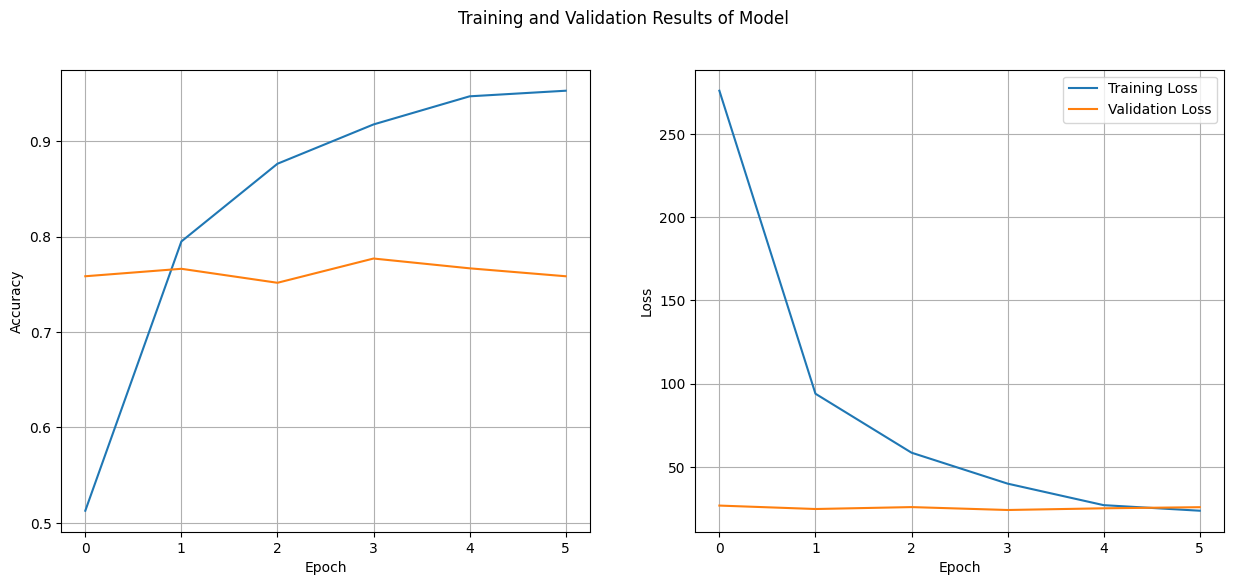

In [22]:
# Training and Validation Results
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].plot(range(6), history[0], label="Training accuracy")
axs[0].plot(range(6), history[2], label="Validation accuracy")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

axs[1].plot(range(6), history[1], label="Training Loss")
axs[1].plot(range(6), history[3], label="Validation Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.suptitle("Training and Validation Results of Model")
plt.legend()
plt.show()

# Submission

In [23]:
test_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,8.658683e-09,1.350807e-09,2.476887e-08,2.528274e-09,3.290966e-03,1.068990e-08,3.212277e-08,6.042293e-08,6.396701e-09,5.207985e-09,...,7.435192e-09,1.585541e-08,1.061348e-08,1.623912e-08,6.922620e-09,1.088412e-09,4.733849e-08,2.664010e-07,3.519193e-08,8.732820e-09
1,1.157665e-07,6.807573e-08,1.115338e-07,1.438885e-07,5.070972e-06,1.161495e-06,2.421715e-06,3.215487e-05,3.004030e-06,7.618534e-07,...,5.011228e-08,1.897785e-07,6.185160e-03,3.944079e-06,2.241203e-06,3.838798e-07,1.238675e-07,6.692240e-06,2.314812e-07,5.422837e-07
2,5.376303e-06,1.918530e-03,5.523525e-05,3.171116e-05,7.717705e-06,2.737671e-06,1.875803e-06,1.101539e-06,9.780687e-06,8.373132e-07,...,5.691004e-06,2.843879e-06,1.524318e-06,1.158456e-05,1.095651e-05,1.152484e-05,1.654118e-06,2.494482e-05,2.422264e-06,4.605874e-06
3,1.528567e-07,8.631365e-08,1.153620e-07,3.641243e-07,1.210938e-05,3.889986e-06,1.522275e-07,2.414052e-05,1.513761e-06,7.580977e-08,...,4.457304e-07,2.718729e-06,1.126582e-06,1.461979e-06,1.949719e-04,8.262730e-08,2.568886e-07,3.264752e-03,1.344281e-06,1.847153e-07
4,2.349520e-08,6.690964e-08,3.813953e-08,1.474034e-07,1.491204e-07,4.055333e-07,2.134735e-07,5.676070e-07,4.195765e-04,1.086510e-06,...,5.286652e-08,5.383134e-08,8.468212e-08,9.843291e-06,2.649634e-08,9.994351e-01,8.445903e-08,4.785823e-08,8.689429e-07,4.080551e-08


In [24]:
# Set columns to breed names
num_classes = []
for num_class in test_preds.columns:
    num_classes.append(num_class)

num_classes = np.array(num_classes)
num_classes = le.inverse_transform(num_classes)
test_preds.columns = list(num_classes)

In [25]:
test_preds.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,8.658683e-09,1.350807e-09,2.476887e-08,2.528274e-09,3.290966e-03,1.068990e-08,3.212277e-08,6.042293e-08,6.396701e-09,5.207985e-09,...,7.435192e-09,1.585541e-08,1.061348e-08,1.623912e-08,6.922620e-09,1.088412e-09,4.733849e-08,2.664010e-07,3.519193e-08,8.732820e-09
1,1.157665e-07,6.807573e-08,1.115338e-07,1.438885e-07,5.070972e-06,1.161495e-06,2.421715e-06,3.215487e-05,3.004030e-06,7.618534e-07,...,5.011228e-08,1.897785e-07,6.185160e-03,3.944079e-06,2.241203e-06,3.838798e-07,1.238675e-07,6.692240e-06,2.314812e-07,5.422837e-07
2,5.376303e-06,1.918530e-03,5.523525e-05,3.171116e-05,7.717705e-06,2.737671e-06,1.875803e-06,1.101539e-06,9.780687e-06,8.373132e-07,...,5.691004e-06,2.843879e-06,1.524318e-06,1.158456e-05,1.095651e-05,1.152484e-05,1.654118e-06,2.494482e-05,2.422264e-06,4.605874e-06
3,1.528567e-07,8.631365e-08,1.153620e-07,3.641243e-07,1.210938e-05,3.889986e-06,1.522275e-07,2.414052e-05,1.513761e-06,7.580977e-08,...,4.457304e-07,2.718729e-06,1.126582e-06,1.461979e-06,1.949719e-04,8.262730e-08,2.568886e-07,3.264752e-03,1.344281e-06,1.847153e-07
4,2.349520e-08,6.690964e-08,3.813953e-08,1.474034e-07,1.491204e-07,4.055333e-07,2.134735e-07,5.676070e-07,4.195765e-04,1.086510e-06,...,5.286652e-08,5.383134e-08,8.468212e-08,9.843291e-06,2.649634e-08,9.994351e-01,8.445903e-08,4.785823e-08,8.689429e-07,4.080551e-08


In [26]:
# Set id column
test_preds = test_preds.reset_index(drop=True)
ids = test_data.loc[:,'id']
test_preds = pd.concat([ids, test_preds], axis=1)
test_preds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,8.658683e-09,1.350807e-09,2.476887e-08,2.528274e-09,3.290966e-03,1.068990e-08,3.212277e-08,6.042293e-08,6.396701e-09,...,7.435192e-09,1.585541e-08,1.061348e-08,1.623912e-08,6.922620e-09,1.088412e-09,4.733849e-08,2.664010e-07,3.519193e-08,8.732820e-09
1,f7a32505c12649183c5991ecfa7d68b3,1.157665e-07,6.807573e-08,1.115338e-07,1.438885e-07,5.070972e-06,1.161495e-06,2.421715e-06,3.215487e-05,3.004030e-06,...,5.011228e-08,1.897785e-07,6.185160e-03,3.944079e-06,2.241203e-06,3.838798e-07,1.238675e-07,6.692240e-06,2.314812e-07,5.422837e-07
2,bc6d50ffb4644feb34530aa58943e85b,5.376303e-06,1.918530e-03,5.523525e-05,3.171116e-05,7.717705e-06,2.737671e-06,1.875803e-06,1.101539e-06,9.780687e-06,...,5.691004e-06,2.843879e-06,1.524318e-06,1.158456e-05,1.095651e-05,1.152484e-05,1.654118e-06,2.494482e-05,2.422264e-06,4.605874e-06
3,7cbc041e79135a572aad87904b5c9c57,1.528567e-07,8.631365e-08,1.153620e-07,3.641243e-07,1.210938e-05,3.889986e-06,1.522275e-07,2.414052e-05,1.513761e-06,...,4.457304e-07,2.718729e-06,1.126582e-06,1.461979e-06,1.949719e-04,8.262730e-08,2.568886e-07,3.264752e-03,1.344281e-06,1.847153e-07
4,f3b603f10d6a344f0395fb46b242ff8e,2.349520e-08,6.690964e-08,3.813953e-08,1.474034e-07,1.491204e-07,4.055333e-07,2.134735e-07,5.676070e-07,4.195765e-04,...,5.286652e-08,5.383134e-08,8.468212e-08,9.843291e-06,2.649634e-08,9.994351e-01,8.445903e-08,4.785823e-08,8.689429e-07,4.080551e-08


In [27]:
test_preds.to_csv('submission.csv', index=None)